In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

from src.utils import util, data_loaders
from src.utils.domain_split import hyperplane_split
from src.model import MLP
from src.train_test import fit_regr, test_regr

seed = npr.randint(10000)
seed = 3838
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# df = pd.read_csv("../../data/regression/naval.txt", delimiter="  ", header=None)
# df.head()
df = pd.read_csv("../../data/regression/naval.csv", index_col=0)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1.138,3.0,289.964,1349.489,6677.380,7.584,7.584,464.006,288.0,550.563,1.096,0.998,5.947,1.019,7.137,0.082,0.95,0.975
1,2.088,6.0,6960.180,1376.166,6828.469,28.204,28.204,635.401,288.0,581.658,1.331,0.998,7.282,1.019,10.655,0.287,0.95,0.975
2,3.144,9.0,8379.229,1386.757,7111.811,60.358,60.358,606.002,288.0,587.587,1.389,0.998,7.574,1.020,13.086,0.259,0.95,0.975
3,4.161,12.0,14724.395,1547.465,7792.630,113.774,113.774,661.471,288.0,613.851,1.658,0.998,9.007,1.022,18.109,0.358,0.95,0.975
4,5.140,15.0,21636.432,1924.313,8494.777,175.306,175.306,731.494,288.0,645.642,2.078,0.998,11.197,1.026,26.373,0.522,0.95,0.975


In [3]:
D = df.values
dom_idx, OOD_idx = hyperplane_split(D, OOD_size=0.2, verbose=1, seed=seed)

# Minmax scaling for better network performace
scaler = MinMaxScaler()
D = df[dom_idx].values
D = scaler.fit_transform(D)

# Split in-domain data to data and labels
X, y = D[:,:-2], D[:,-2:]

# Split to train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=seed)

# Separate OOD data
OOD = df[OOD_idx].values
OOD = scaler.transform(OOD)         # need to also transform it to be compatible with the NN.
X_OOD, y_OOD = OOD[:,:-2], OOD[:,-2:]

# Hyperparameters
n_features = X_train.shape[1]
n_classes = 2
n_hidden_1 = 100
n_hidden_2 = 30
network = [n_hidden_1, n_hidden_2]
activation = 'relu'
n_epochs = 10000
learning_rate = 0.0001
weight_decay = 1e-5
batch_size = 64

# Tensor datasets
train_dataset = data_loaders.create_torch_dataset(X_train, y_train, to_LongTensor=False)
test_dataset = data_loaders.create_torch_dataset(X_test, y_test, to_LongTensor=False)
OOD_dataset = data_loaders.create_torch_dataset(X_OOD, y_OOD, to_LongTensor=False)

# Data loaders on gpu
train_loader = data_loaders.create_loader(train_dataset, batch_size, device)
test_loader = data_loaders.create_loader(test_dataset, batch_size, device)
OOD_loader = data_loaders.create_loader(OOD_dataset, batch_size, device)

Found random direction n = [ 0.26962854 -0.13544917 -0.03843235  0.19826846 -0.02576374  0.10997481
 -0.14899074 -0.15526795  0.25011833 -0.02175058 -0.69558197  0.12784518
  0.07634606 -0.25895559  0.19435762  0.23671701  0.25610534 -0.11663837]
Found split with ratio r = 0.20085470085470086


### Abs

In [8]:
activation = 'abs'
network = [32]

Loss on dev set has stopped decreasing after epoch 1378 (average of 50 epochs).
STOPPING EARLY.
Average Train MSE: 0.00013


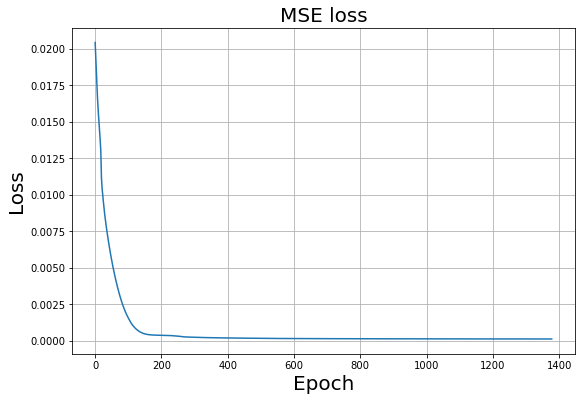

Average test MSE = 0.00015
Average OOD loss = 0.0024843905
Average OOD loss to train loss ratio:  19.348
Average OOD loss to test loss ratio:  16.716


In [9]:
model = MLP(n_features, 2, network, activation, batch_norm=True).to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Train
train_losses = fit_regr(model, loss_function, optimizer, train_loader, 
    n_epochs=n_epochs, verbose=1, early_stopping='dev', return_losses=True)
avg_train_loss = train_losses[-1]

print(f"Average Train MSE: {avg_train_loss:.5f}")  

plt.figure(figsize=(9,6))
plt.plot(train_losses)
plt.grid()
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.title("MSE loss", fontsize=20)
plt.show()

avg_test_loss = test_regr(model, loss_function, test_loader, return_loss=True)

print(f"Average test MSE = {avg_test_loss:.5f}")   

avg_OOD_loss = test_regr(model, loss_function, OOD_loader, return_loss=True)

print(f"Average OOD loss = {avg_OOD_loss:.10f}")  
print(f"Average OOD loss to train loss ratio: {avg_OOD_loss / avg_train_loss : .3f}")
print(f"Average OOD loss to test loss ratio: {avg_OOD_loss / avg_test_loss : .3f}")

### ReLU

In [5]:
activation = 'relu'

In [4]:
model = MLP(n_features, n_classes, network, activation, batch_norm=True).to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

Loss on dev set has stopped decreasing after epoch 315 (average of 50 epochs).
STOPPING EARLY.
Average Train MSE: 0.00005
Total Train MSE: 0.22396


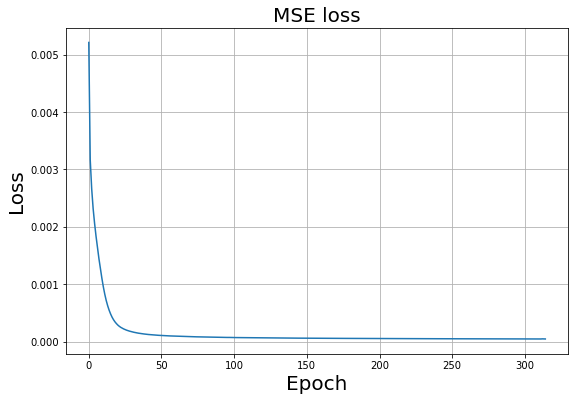

In [5]:
train_losses = fit_regr(model, loss_function, optimizer, train_loader, n_epochs=n_epochs,
                        verbose=1, early_stopping='dev', return_losses=True)
avg_train_loss = train_losses[-1]

print(f"Average Train MSE: {avg_train_loss:.5f}")
print(f"Total Train MSE: {len(X_train) * avg_train_loss:.5f}")

plt.figure(figsize=(9,6))
plt.plot(train_losses)
plt.grid()
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.title("MSE loss", fontsize=20)
plt.show()

In [6]:
avg_test_loss = test_regr(model, loss_function, test_loader, return_loss=True)

print(f"Average test MSE = {avg_test_loss:.5f}")   
print(f"Total test MSE: {len(X_test) * avg_train_loss:.5f}")

Average test MSE = 0.00007
Total test MSE: 0.22401


In [7]:
avg_OOD_loss = test_regr(model, loss_function, OOD_loader, return_loss=True)

print(f"Average OOD loss = {avg_OOD_loss:.10f}")  
print(f"Average OOD loss to train loss ratio: {avg_OOD_loss / avg_train_loss : .3f}")
print(f"Average OOD loss to test loss ratio: {avg_OOD_loss / avg_test_loss : .3f}")

Average OOD loss = 0.0059553687
Average OOD loss to train loss ratio:  126.787
Average OOD loss to test loss ratio:  86.761


In [31]:
def pipeline(X_train, X_test, y_train, y_test, verbose=0):
    
    # Transformation required for regression problem
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    # Tensor datasets
    train_dataset = data_loaders.create_torch_dataset(X_train, y_train, to_LongTensor=False)
    test_dataset = data_loaders.create_torch_dataset(X_test, y_test, to_LongTensor=False)

    # Data loaders on gpu
    train_loader = data_loaders.create_loader(train_dataset, batch_size, device)
    test_loader = data_loaders.create_loader(test_dataset, batch_size, device)

    # Model setup
    model = MLP(n_features, 1, network, activation).to(device)

    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # fit function optionally returns a list with the epoch-wise losses
    train_loss = fit_regr(model, loss_function, optimizer, train_loader, 
                 n_epochs=n_epochs, verbose=1, early_stopping=True, return_losses=True) 
    test_loss = test_regr(model, loss_function, test_loader, verbose=0, return_loss=True) 
    
    if verbose:
        print(f"Average Train MSE Loss: {train_loss[-1] : .10f}")
        print(f"Average Test MSE Loss : {test_loss : .10f}" )

    return train_loss, test_loss                 # train loss is a list, test loss is a float
 


Training on fold no. 1
Loss has stopped decreasing after epoch 152 (average of 50 epochs).
STOPPING EARLY.
Average Train MSE Loss:  0.0001394783
Average Test MSE Loss :  0.0032228815

Training on fold no. 2
Loss has stopped decreasing after epoch 179 (average of 50 epochs).
STOPPING EARLY.
Average Train MSE Loss:  0.0001291957
Average Test MSE Loss :  0.0037405792

Training on fold no. 3
Loss has stopped decreasing after epoch 169 (average of 50 epochs).
STOPPING EARLY.
Average Train MSE Loss:  0.0001569484
Average Test MSE Loss :  0.0030567419

Training on fold no. 4
Loss has stopped decreasing after epoch 164 (average of 50 epochs).
STOPPING EARLY.
Average Train MSE Loss:  0.0001339548
Average Test MSE Loss :  0.0009278679

Training on fold no. 5
Loss has stopped decreasing after epoch 145 (average of 50 epochs).
STOPPING EARLY.
Average Train MSE Loss:  0.0001395873
Average Test MSE Loss :  0.0016236231

Training on fold no. 6
Loss has stopped decreasing after epoch 129 (average of 

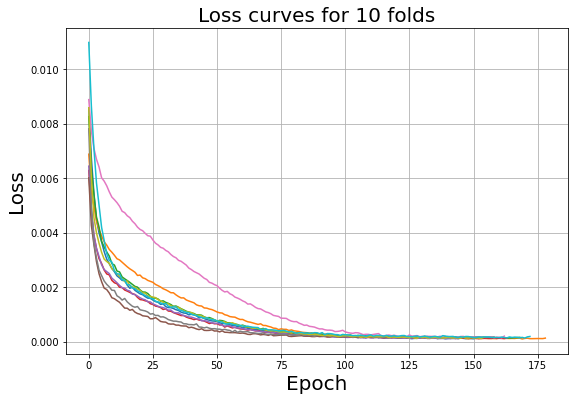

In [32]:
n_splits = 10
kf = KFold(n_splits)

train_losses = np.zeros(n_splits)
test_losses = np.zeros(n_splits)
train_losses_plot = []                           # for plotting loss curves
for i, (train_index, test_index) in enumerate(kf.split(X)):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("\nTraining on fold no. %d" %(i+1))
    epoch_wise_train_losses, test_losses[i] = pipeline(X_train, X_test, y_train, y_test, verbose=1)
    train_losses[i] = epoch_wise_train_losses[-1]
    train_losses_plot.append(epoch_wise_train_losses)
    
print("\nTrain losses:", train_losses)
print("\nTest losses:", test_losses)

avg_train_loss_k_folds = train_losses.mean() 
avg_test_loss_k_folds = test_losses.mean() 
print(f"\nAvg train loss over all folds: {avg_train_loss_k_folds :.5f}")
print(f"Avg total train loss over all folds: {len(X_train) * avg_train_loss_k_folds :.5f}")
print(f"\nAvg test loss over all folds: {avg_test_loss_k_folds :.5f}")
print(f"Avg total test loss over all folds: {len(X_test) * avg_test_loss_k_folds :.5f}")

plt.figure(figsize=(9,6))
for losses in train_losses_plot:
    plt.plot(losses)
plt.grid()
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.title(f"Loss curves for {n_splits} folds", fontsize=20)
plt.show()